### Exploratory analysis of Covid cases and vaccination data in Federal District

The objective of this study is to make exploratory analysis about Covid new cases/deaths and try to understand how these two variables behaved after the start of vaccine applications in Federal District.

Cases and vaccination information were found in two different government sources, so they had to be treated separatly and then merged by date. This way we can see in a time series line plot how this event occurred since August 5th, 2020. 

Considering it is highly effective if people have both doses, the final variables i chose for the analysis were:
1. New confirmed cases
2. New deaths
3. Initial dose
4. Second dose
5. Third dose

*Obs: Items 3 and 4 were kept only for interactive tests in final chart.*

In [1]:
#### Import libraries #### 

## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
import missingno as msno

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
import xgboost

**Dealing with vaccines dataset:** https://opendatasus.saude.gov.br/dataset/covid-19-vacinacao

In [ ]:
# read three csv files containing all data available regarding to vaccination in Federal District
df_part0 = pd.read_csv("part-3.csv", sep = ";")
df_part1 = pd.read_csv("part-1.csv", sep = ";")
df_part2 = pd.read_csv("part-2.csv", sep = ";")

In [ ]:
# set dtype of date variable
df_part0['vacina_dataAplicacao'] = pd.to_datetime(df_part0['vacina_dataAplicacao'])
df_part1['vacina_dataAplicacao'] = pd.to_datetime(df_part1['vacina_dataAplicacao'])
df_part2['vacina_dataAplicacao'] = pd.to_datetime(df_part2['vacina_dataAplicacao'])

In [ ]:
# get general information about cases data
dtf.info()

In [ ]:
# set date feature as index
df_part0 = df_part0.set_index(['vacina_dataAplicacao'])
df_part1 = df_part1.set_index(['vacina_dataAplicacao'])
df_part2 = df_part2.set_index(['vacina_dataAplicacao'])

In [ ]:
# set correct dtypes
df = df_part0[["document_id", "vacina_descricao_dose"]]
df = df.append([df_part1[["document_id", "vacina_descricao_dose"]], df_part2[["document_id", "vacina_descricao_dose"]]])

In [ ]:
# Create dummies
# vacina_descricao_dose
dummy = pd.get_dummies(df["vacina_descricao_dose"], drop_first = True)
df = pd.concat([df, dummy], axis = 1)
df.drop("vacina_descricao_dose", inplace = True, axis = 1)

In [ ]:
# rename index as 'date'
df.index.names = ['date']

In [ ]:
# group doses information by date
df = df.groupby(level = "date").sum()

In [ ]:
# sum doses application by date
df["DoseTotal"] = df.sum(axis = 1)

In [ ]:
# save dataframe
df.to_csv("vacinas.csv")

**Dealing with cases dataset and merging it:** https://brasil.io/dataset/covid19/caso_full/

In [25]:
# Read vaccine treated data and cases data
dtf_vacinas = pd.read_csv("vacinas.csv")
dtf = pd.read_csv("caso_full.csv", parse_dates = True)
dtf = dtf.loc[dtf["state"] == "DF"]

In [26]:
# get general information about cases data
dtf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234 entries, 564443 to 566676
Data columns (total 18 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   city                                           1483 non-null   object 
 1   city_ibge_code                                 1502 non-null   float64
 2   date                                           2234 non-null   object 
 3   epidemiological_week                           2234 non-null   int64  
 4   estimated_population                           1502 non-null   float64
 5   estimated_population_2019                      1502 non-null   float64
 6   is_last                                        2234 non-null   bool   
 7   is_repeated                                    2234 non-null   bool   
 8   last_available_confirmed                       2234 non-null   int64  
 9   last_available_confirmed_per_100k_inhabitants

In [27]:
# setting date as index
dtf = dtf.set_index(['date'])
dtf.index = pd.to_datetime(dtf.index)
dtf.index

dtf_vacinas = dtf_vacinas.set_index(['date'])
dtf_vacinas.index = pd.to_datetime(dtf_vacinas.index)
dtf_vacinas.index

DatetimeIndex(['2020-01-07', '2020-01-28', '2020-01-29', '2020-02-26',
               '2020-08-05', '2020-08-06', '2020-08-13', '2020-08-17',
               '2020-08-19', '2020-08-20',
               ...
               '2022-03-26', '2022-03-27', '2022-03-28', '2022-03-29',
               '2022-03-30', '2022-03-31', '2022-04-01', '2022-04-02',
               '2022-04-03', '2022-04-04'],
              dtype='datetime64[ns]', name='date', length=549, freq=None)

In [28]:
# create function to evaluate how many categorical and numerical variables there are and the proportion of missing data
def utils_recognize_type(dtf, col, max_cat = 20):
    if (dtf[col].dtype == "O"):# | (dtf[col].nunique() <= max_cat):
        return "cat"
    elif dtf[col].dtype == 'datetime64[ns]':
        return "datetime"
    elif dtf[col].dtype == 'bool':
        return "bool"
    else:             
        return "num"

In [29]:
dic_cols = {col:utils_recognize_type(dtf = dtf, col = col, max_cat=20) for col in dtf.columns}

print(dic_cols)

{'city': 'cat', 'city_ibge_code': 'num', 'epidemiological_week': 'num', 'estimated_population': 'num', 'estimated_population_2019': 'num', 'is_last': 'bool', 'is_repeated': 'bool', 'last_available_confirmed': 'num', 'last_available_confirmed_per_100k_inhabitants': 'num', 'last_available_date': 'cat', 'last_available_death_rate': 'num', 'last_available_deaths': 'num', 'order_for_place': 'num', 'place_type': 'cat', 'state': 'cat', 'new_confirmed': 'num', 'new_deaths': 'num'}


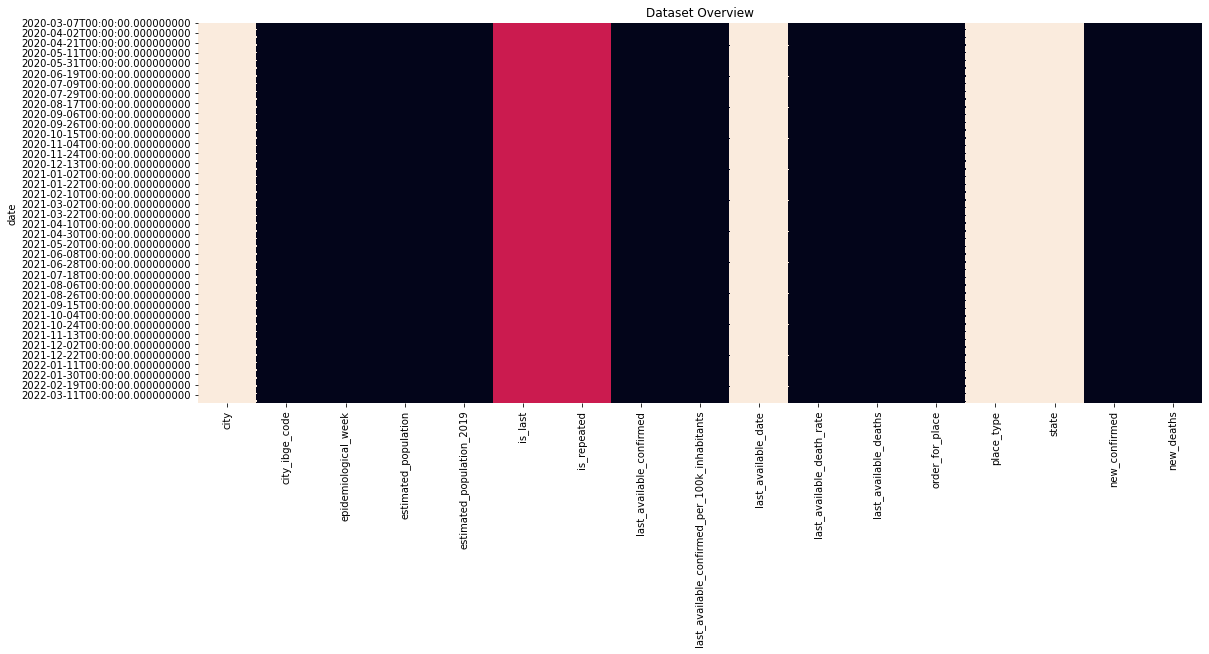

 Numeric   Categorical   Boolean 


In [30]:
# create heatmap to visualize features types in dataset
heatmap = dtf.isnull()

for k,v in dic_cols.items():
    #if v == "datetime":
        #heatmap[k] = heatmap[k].apply(lambda x: 2 if x is False else 1)
    if v == "num":
        heatmap[k] = heatmap[k].apply(lambda x: 0)
    elif v == "bool":
        heatmap[k] = heatmap[k].apply(lambda x: 0.5)
    else:
        heatmap[k] = heatmap[k].apply(lambda x: 1)
        

fig, ax = plt.subplots(figsize=(18,7))
sns.set_style({'axes.labelcolor': 'white'})
sns.heatmap(heatmap, cbar = False).set_title("Dataset Overview")
plt.show()

print("\033[1;37;40m Numeric ", "\033[1;30;47m Categorical ", "\033[1;30;41m Boolean ")

<AxesSubplot:>

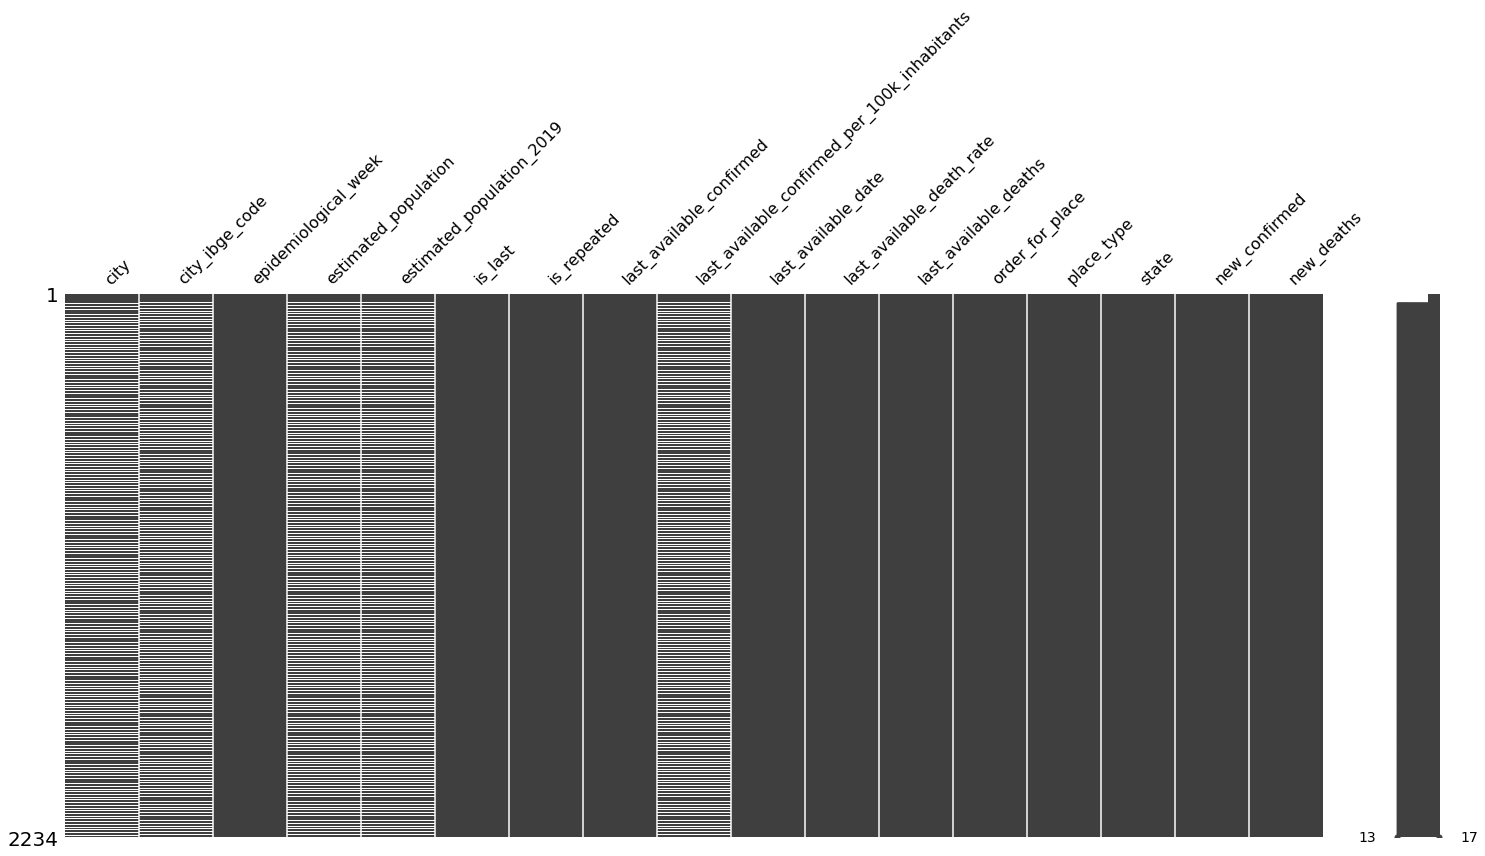

In [32]:
# Visualize missing values with missingno
msno.matrix(dtf)

In [33]:
# identify features percentage of missing values
for feature in dtf.columns:
    if round(dtf[feature].isnull().sum()*100/len(dtf), 4) > 0: 
        print(feature, round(dtf[feature].isnull().sum()*100/len(dtf), 4), '% of missing values')
         

city 33.6168 % of missing values
city_ibge_code 32.7663 % of missing values
estimated_population 32.7663 % of missing values
estimated_population_2019 32.7663 % of missing values
last_available_confirmed_per_100k_inhabitants 32.7663 % of missing values


In [34]:
# group and summarize cases data frame by date and maintaining estimated_population and last_available_deaths
dtf = dtf.groupby(["date", "estimated_population", "last_available_deaths"]).sum()

In [35]:
dtf = dtf.reset_index(level = ["estimated_population", "last_available_deaths"])

In [36]:
# select only important features regarding the analysis  
dtf = dtf[["new_confirmed", "new_deaths"]]

In [37]:
# merge both dataframes
dtf = pd.merge(dtf, dtf_vacinas[["Dose Inicial", "2ª Dose", "3ª Dose"]], left_index=True, right_index=True)
display(dtf)

,new_confirmed,new_deaths,Dose Inicial,2ª Dose,3ª Dose
date,,,,,
2020-08-05,1835,31,0.0,0.0,0.0
2020-08-05,2042,33,0.0,0.0,0.0
2020-08-06,2130,43,0.0,0.0,0.0
2020-08-06,2034,46,0.0,0.0,0.0
2020-08-13,1753,33,0.0,0.0,0.0
...,...,...,...,...,...
2022-03-25,339,4,0.0,3475.0,0.0
2022-03-26,0,0,0.0,1433.0,0.0
2022-03-26,0,0,0.0,1433.0,0.0


Scaling data is important in this type of analysis because the range of variables may differ a lot, and using the original scale may put more weight on the variables with a large range. Typically, it ensures that the mean and the standard deviation are 0 and 1, respectively.

To be able to compare features, i used the RobustScaler. This scaler differs from others because it removes the median, not mean, and scales data according to the quantile range, minimizing outliers influence.

In [38]:
# Scale features to be able to compare them
## scale X
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
X = scalerX.fit_transform(dtf)
dtf_scaled= pd.DataFrame(X, columns=dtf.columns, index=dtf.index)

The correlation matrix below don't show any significant values between features. 

Vaccination may cause a posterior efect in number of new deaths, but evaluating future impact of a feature may be topic for another studie. 

Text(0.5, 1.0, 'pearson correlation')

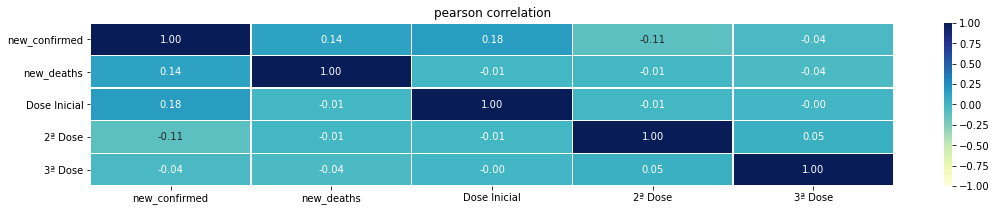

In [39]:
# correlation matrix
corr_matrix = dtf_scaled.corr(method="pearson")

fig, ax = plt.subplots(figsize=(18, 3))
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, ax = ax)
plt.title("pearson correlation")

**Now let's visualize all features in a line plot to see what we can get.** 

In [40]:
# Create function to visualize features lines in a interactive way 
def f(x1,x2,x3):
    fig = px.line(data_frame = dtf_scaled, 
                      x = dtf_scaled.index, 
                      y = [x1, x2, x3], 
                      title= (x1.replace("_", " ").title() + "    Vs    " + x2.replace("_", " ").title() + "    Vs    " + x3.replace("_", " ").title()),
                      labels={
                          "x": "",
                          "value": "",
                          "variable": "Variables"
                      },
                     template = "plotly_dark")
    fig.update_layout(font_size = 10)

    fig.show()       


Using "widgets" is very usefull tool in data visualization because it allows you to interactively alternate among variables with out rewriting the code.

In [41]:
widgets.interact(f, x1 = dtf_scaled.columns, x2 = dtf_scaled.columns, x3 = dtf_scaled.columns)

interactive(children=(Dropdown(description='x1', options=('new_confirmed', 'new_deaths', 'Dose Inicial', '2ª D…

<function __main__.f(x1, x2, x3)>

##### It's interesting to note that there are three importante peaks in the occurrence of new confirmed cases:

  The first was between Mar and May, 2021 and it can be justified by carnaval holidays (Feb 12th - 17th). Although traditional festivities were not allowed, it is known that Brazilians never give up and went travelling and had informal parties.
    
  The second one was really especific, at October 5th, 2021. It may or may not be related to the release of public events in the federal district, published in the official journal of the union, at september 22th, but it's a important information to be ponctuated.
    
  The thrid and highest peak was, again, between Jan and Mar, 2022. This period represent summer and carnaval em Brazil and, as showed in chart, the number of new cases and deaths were low and the government had applyed a good number of second doses in Federal District population. What i'm trying to say is: people traveled and had aglomeration parties as if tomorrow would never come. It came... with a great increase in new confirmed cases.  
    
##### With the information contained in these datasets, causality between vaccination and new deaths can not be inferred, but clearly the appearance of new deaths stabilized right after the start of 2º doses applications. 